# Project scope

Create a classifier that predicts how my day was based on inputs.

Simplest possible pipeline just uses the productive and unproductive hours. 

Assumptions: the survey methodology was consistent throughout (which it mostly was). So I'm looking to predict how my day will be based on what I do during the day. It doesn't predict what I do during my day (I guess we could do that too, but it would be wildly inaccurate without a pretty insane number of features). 

The hours are a number from one through 8 (I was inconsistent with that, sometimes I would write higher numbers but really it should cap at 8). So there's a preprocessing step there.

Note this is a pretty small amount of data.

In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')

# Get data

The data is from Sheets - I can even do my cleaning there if I want. That's probably better for the actual correction of individual pieces of data. But if there is actual preprocessing that needs to be done, it should be done in Python.

The preprocessing step is just dropping NaNs - so if we had a month worth of new test data coming in in the same format, we would just drop any NaNs before running. 

In [2]:
path = "base data (dnc)/Daily Recap (Responses) - RAW form responses.csv"
raw_target = 'How would you rate your overall satisfaction for the day?'

df = pd.read_csv(path).dropna(subset=[raw_target])  # ensure no missing y values

# pre-split preprocessing

target_map = {"Terrible day": 0, "Not great day": 1, "Okay day": 2, "Good day": 3, "Incredible day": 4}
df['target'] = df[raw_target].replace(target_map)
target = 'target'


train, test, y, y_test = train_test_split(df.drop(target, axis=1), df[target], random_state = 0)
# train.columns
df[target]

0      3
1      3
2      2
3      3
4      2
      ..
331    4
332    1
333    2
334    3
335    2
Name: target, Length: 320, dtype: int64

In [23]:
print(target_map)

{'Terrible day': 0, 'Not great day': 1, 'Okay day': 2, 'Good day': 3, 'Incredible day': 4}


# Explore data

- What's a baseline to beat? (random, most common value)
- check out distribution of target (do i need to encode the target?)

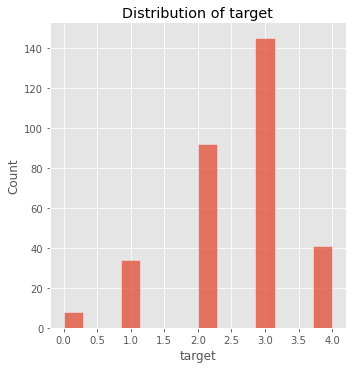

In [3]:
sns.displot(df[target])

plt.title('Distribution of target');

In [4]:
len(df.loc[(df[target] == "Good day")]) / len(df)

0.0

So the prediction points to beat are 20% and 45%. 

# Feature selection

In [8]:
features = ['Productive Hours', 'Productive AI Hours', 'Unproductive Hours']
X = train[features].copy()
X_test = test[features].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, random_state=0)  # very basic model (?) plot change in performance vs training time?

In [11]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Accuracy scores (in %):\n", scores*100)
print("Average accuracy score (across experiments):")
print(scores.mean()*100)

Accuracy scores (in %):
 [45.83333333 58.33333333 52.08333333 39.58333333 41.66666667]
Average accuracy score (across experiments):
47.5


Wow, that's kind of low. But not that surprising give that I just gave it a bunch of numbers. Wait, does y need to be encoded?

I guess let's get the scoring working and then we can see how much it improves it. 

In [12]:
model.fit(X, y)
model.score(X_test, y_test)

0.4625

In [29]:
# test_predictions

def getKey(dct,value):  # works for unique values; might be better to reverse dict instead
     return [key for key in dct if (dct[key] == value)]

getKey(target_map, model.predict([[8, 5, 2]]))

['Good day']

I think I just want to be better than picking the same guess every time. Random would be 20% expected accuracy, I need to do exploratory analysis to determine what the most common value is (e.g. if I just guessed "okay day" every day). I hope it's under 50%. Oh shit, is this data imbalanced?